## Dataset: Kaggle NLP with Disaster Tweets
Predict which Tweets are about real disasters and which ones are not
- https://www.kaggle.com/c/nlp-getting-started/overview

Deep Learning Dense Classifier with a small BERT_L-10_H-256 encoder using TensorFlow and Keras API

In [ ]:
!pip -qq install tweet-preprocessor
!pip -qq install tensorflow_hub
!pip -qq install tensorflow_text
!pip -qq install pydot

     |████████████████████████████████| 4.9 MB 5.3 MB/s 
     |████████████████████████████████| 462 kB 46.8 MB/s 


In [ ]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import preprocessor as p
from sklearn.model_selection import train_test_split

In [ ]:
!nvidia-smi

Thu Mar 17 20:37:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.65       Driver Version: 511.65       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   58C    P3    21W /  N/A |   4684MiB /  6144MiB |     66%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# path = "C:/Users/erich/OneDrive/Erich/02_Studies/Data_Science/Machine_Learning/Deep_Learning/Disaster_Tweets_NLP"
path = ""
train_data_path = os.path.join(path, "data", "train.csv")
test_data_path = os.path.join(path, "data", "test.csv")

In [ ]:
raw_data = pd.read_csv(train_data_path)
raw_data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [ ]:
# Text cleaning - Removing URLs, mentions, etc using tweet-preprocessor package
def tweet_clean(tweet, lower_case = False, remove_digits = False,
                remove_punct = False, replace_amper = False,
                retrieve_hashtag = True):
  """
  Clean tweet with tweet-preprocessor p.clean() removing unwanted characters,
  user mentions, punctuations and setting to lower case text.

  Arguments:
  tweet -- Text string.
  lower_case -- Boolean. When True, will lower case tweets. Default = False.
  remove_digits -- Boolean. When True, will remove numbers from tweets.
  Default = False.
  remove_punct -- Boolean. When True, will remove punctuations from tweets.
  Default = False.
  replace_amper -- Boolean. When True, will replace HTML ampersand format for
  'and' stopword. Default = False.
  retrieve_hashtage -- Boolean. When True, will retrieve tweet hashtag in an
  independent series object 'hashtags'. Default = True.
  
  Returns:
  cleaned_tweet -- Cleaned tweet text string.
  hashtags -- List with hashtags extracted from tweet
  """
  # Remove user mentions, symbols and unwanted characters
  p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.RESERVED,
                p.OPT.EMOJI, p.OPT.SMILEY)
  
  tweet = p.clean(tweet)

  # Lower case
  if lower_case:
    tweet = tweet.lower()

  # Remove digits
  if remove_digits:
    tweet = tweet.replace('\d+', '')

  # Remove punctuations
  if remove_punct:
    tweet = re.sub(r'[^\w\s]', '', tweet)
  
  # Replace amper
  if replace_amper:
    tweet = tweet.replace('&amp;', 'and')
    tweet = tweet.replace('&AMP;', 'and')

  if retrieve_hashtag:
    hashtags = re.findall(r'#(\w+)', tweet)
    tweet = tweet.replace('#', '')

  cleaned_tweet = tweet

  if retrieve_hashtag:
    return pd.Series([cleaned_tweet, hashtags])
  else:
    return cleaned_tweet

In [ ]:
raw_data['cleaned_text'] = raw_data['text'].apply(tweet_clean,
                                                  replace_amper = True,
                                                  retrieve_hashtag = False)
raw_data

,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,Two giant cranes holding a bridge collapse int...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,The out of control wild fires in California ev...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii.
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,Police investigating after an e-bike collided ...


In [ ]:
print('Tweet text before cleaning: ', list(raw_data.loc[raw_data['id'] == 530, 'text']))
print('Tweet text after cleaning: ', list(raw_data.loc[raw_data['id'] == 530, 'cleaned_text']))

Tweet text before cleaning:  ['Beyonce Is my pick for http://t.co/nnMQlz91o9 Fan Army #Beyhive http://t.co/o91f3cYy0R 72']
Tweet text after cleaning:  ['Beyonce Is my pick for Fan Army #Beyhive 72']


In [ ]:
raw_data['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(raw_data['cleaned_text'], raw_data['target'],
                                                  train_size = 0.8,
                                                  random_state = 1337,
                                                  shuffle = True,
                                                  stratify = raw_data['target'])

In [ ]:
print(f"Training data shape: {X_train.shape}")
print(f"Training label shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Validation label shape: {y_val.shape}")

Training data shape: (6090,)
Training label shape: (6090,)
Validation data shape: (1523,)
Validation label shape: (1523,)


In [ ]:
batch_size = 64
train_df = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size = batch_size)
val_df = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size = batch_size)

In [ ]:
for inputs, targets in train_df:
  print("inputs.shape:", inputs.shape)
  print("inputs.dtype:", inputs.dtype)
  print("targets.shape:", targets.shape)
  print("targets.dtype:", targets.dtype)
  print("inputs[0]:", inputs[0])
  print("targets[0]:", targets[0])
  break

inputs.shape: (64,)
inputs.dtype: <dtype: 'string'>
targets.shape: (64,)
targets.dtype: <dtype: 'int64'>
inputs[0]: tf.Tensor(b'A young German stormtrooper engaged in the Battle of the Somme 1916. [800 582 ]', shape=(), dtype=string)
targets[0]: tf.Tensor(1, shape=(), dtype=int64)


In [ ]:
BERT_preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name = "BERT_Preprocessor")
BERT_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/2", trainable = True, name = "BERT_256-10_Encoder")

In [ ]:
def get_embedding(sequences):
  preprocessed_sequences = BERT_preprocessor(sequences)
  encoded_sequences = BERT_encoder(preprocessed_sequences)['pooled_output']
  return encoded_sequences

In [ ]:
get_embedding(["This is a test sentence!", "Another one incoming"])

<tf.Tensor: shape=(2, 256), dtype=float32, numpy=
array([[-6.01756871e-01, -8.09544444e-01, -9.05560553e-01,
        -2.80527603e-02, -9.92211819e-01, -2.99887568e-01,
         9.91455257e-01, -7.50085950e-01, -5.99015951e-01,
        -1.27246752e-01, -1.17971249e-01, -6.18989542e-02,
         8.64751786e-02,  9.93143559e-01, -9.42964628e-02,
         4.15551782e-01,  9.71119046e-01, -9.99941409e-01,
         5.82133830e-02,  5.64389765e-01,  9.50350940e-01,
        -9.97890949e-01, -2.29092643e-01, -9.75448012e-01,
        -9.65640306e-01, -9.82125878e-01, -1.63278863e-01,
        -9.99618649e-01, -2.00515792e-01, -9.44717586e-01,
         9.08346236e-01,  8.87407959e-01, -9.99967098e-01,
        -8.03352967e-02,  1.00704007e-01,  3.28888983e-01,
         6.36177957e-02,  9.83363330e-01,  9.99628484e-01,
        -9.98949647e-01, -9.98481810e-01, -9.68110204e-01,
         6.51714265e-01, -9.94027197e-01,  9.97748196e-01,
         1.19884051e-01,  9.99978364e-01,  9.99444008e-01,
      

In [ ]:
def get_dropout_model():
  inputs = tf.keras.layers.Input(shape = (), dtype = tf.string, name = "Input_Text")
  x = BERT_preprocessor(inputs)
  x = BERT_encoder(x)
  x = tf.keras.layers.Dropout(0.1)(x['pooled_output'])
  outputs = tf.keras.layers.Dense(1, activation = "sigmoid", name = "Binary_Classifier")(x)
  
  model = tf.keras.Model(inputs, outputs)

  return model

In [ ]:
model = get_dropout_model()

# Low learning_rate adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-5)

model.compile(optimizer = optimizer,
              loss = "binary_crossentropy",
              metrics = ["accuracy", tf.keras.metrics.AUC(name = "auc")])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Text (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 BERT_Preprocessor (KerasLayer)  {'input_mask': (Non  0          ['Input_Text[0][0]']             
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [ ]:
model_file_path = os.path.join(path, "models", "dropout_BERT-small.keras")

callbacks = [tf.keras.callbacks.ModelCheckpoint(model_file_path,
                                                save_best_only = True,
                                                monitor = 'val_auc')]

history = model.fit(train_df,
                    validation_data = val_df,
                    epochs = 20,
                    callbacks = callbacks)

Epoch 1/20
96/96 [==============================] - 102s 997ms/step - loss: 0.6667 - accuracy: 0.5829 - auc: 0.6282 - val_loss: 0.6323 - val_accuracy: 0.6054 - val_auc: 0.6433
Epoch 2/20
96/96 [==============================] - 93s 967ms/step - loss: 0.6574 - accuracy: 0.6312 - auc: 0.6557 - val_loss: 0.5751 - val_accuracy: 0.7571 - val_auc: 0.7487
Epoch 3/20
96/96 [==============================] - 93s 967ms/step - loss: 0.5434 - accuracy: 0.7631 - auc: 0.7868 - val_loss: 0.5154 - val_accuracy: 0.7728 - val_auc: 0.8191
Epoch 4/20
96/96 [==============================] - 93s 969ms/step - loss: 0.5013 - accuracy: 0.7795 - auc: 0.8201 - val_loss: 0.4853 - val_accuracy: 0.7866 - val_auc: 0.8304
Epoch 5/20
96/96 [==============================] - 96s 1s/step - loss: 0.4554 - accuracy: 0.8115 - auc: 0.8470 - val_loss: 0.4919 - val_accuracy: 0.7774 - val_auc: 0.8448
Epoch 6/20
96/96 [==============================] - 93s 969ms/step - loss: 0.4067 - accuracy: 0.8343 - auc: 0.8819 - val_loss: 

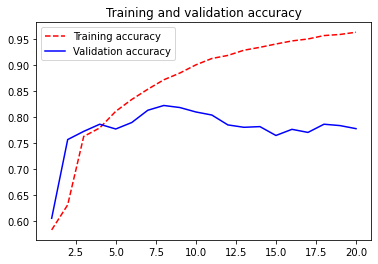

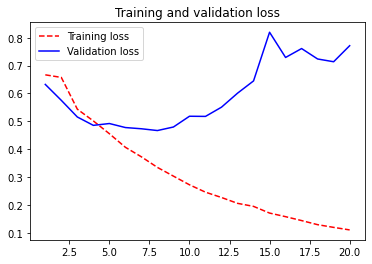

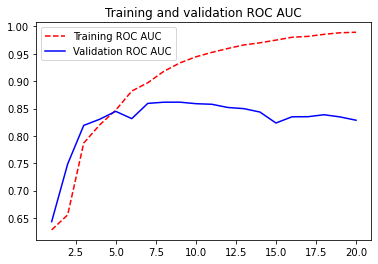

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
auc = history.history["auc"]
val_auc = history.history["val_auc"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "r--", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b-", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b-", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.figure()
plt.plot(epochs, auc, "r--", label="Training ROC AUC")
plt.plot(epochs, val_auc, "b-", label="Validation ROC AUC")
plt.title("Training and validation ROC AUC")
plt.legend()
plt.show()

In [ ]:
# Evaluating the model
import numpy as np
from sklearn.metrics import f1_score, classification_report

model = tf.keras.models.load_model(model_file_path, custom_objects={'KerasLayer': hub.KerasLayer})
y_pred = model.predict(X_val)

In [ ]:
# F1-score
y_pred_hard = np.where(y_pred > 0.5, 1, 0)
f1_score(y_val, y_pred_hard)

0.659103800340329

In [ ]:
# Classification report
print(classification_report(y_val, y_pred_hard))

              precision    recall  f1-score   support

           0       0.82      0.39      0.53       869
           1       0.52      0.89      0.66       654

    accuracy                           0.61      1523
   macro avg       0.67      0.64      0.60      1523
weighted avg       0.69      0.61      0.59      1523



In [ ]:
# Preparing complete df for final training on complete train.csv
X, y = raw_data['cleaned_text'], raw_data['target']

complete_df = tf.data.Dataset.from_tensor_slices((X, y)).batch(batch_size = batch_size)

In [ ]:
# Fitting the model to the complete train.csv dataset
model = get_dropout_model()

# Low learning_rate adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-5)

model.compile(optimizer = optimizer,
              loss = "binary_crossentropy",
              metrics = ["accuracy", tf.keras.metrics.AUC(name = "auc")])

history = model.fit(complete_df,
                    epochs = 5)

Epoch 1/5
119/119 [==============================] - 112s 887ms/step - loss: 0.3307 - accuracy: 0.8801 - auc: 0.9196
Epoch 2/5
119/119 [==============================] - 114s 962ms/step - loss: 0.2344 - accuracy: 0.9263 - auc: 0.9516
Epoch 3/5
119/119 [==============================] - 127s 1s/step - loss: 0.2109 - accuracy: 0.9289 - auc: 0.9611
Epoch 4/5
119/119 [==============================] - 104s 870ms/step - loss: 0.1926 - accuracy: 0.9352 - auc: 0.9683
Epoch 5/5
119/119 [==============================] - 103s 868ms/step - loss: 0.1703 - accuracy: 0.9454 - auc: 0.9752


In [ ]:
# Processing test dataset
test_data = pd.read_csv(test_data_path)
test_text = test_data['text'].apply(tweet_clean,
                                    replace_amper = True,
                                    retrieve_hashtag = False)

test_df = tf.data.Dataset.from_tensor_slices((test_text)).batch(batch_size = batch_size)

In [ ]:
# Inference
y_test = model.predict(test_df)
y_test_hard = np.where(y_test > 0.5, 1, 0)

sample_submission_data_path = os.path.join(path, "data", "sample_submission.csv")
submission = pd.read_csv(sample_submission_data_path)
submission['target'] = y_test_hard

submission.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,0
6,21,0
7,22,0
8,27,0
9,29,0


In [ ]:
# Saving submission.csv file
BERT_small_submission_data_path = os.path.join(path, "data", "BERT-small_submission.csv")
submission.to_csv(BERT_small_submission_data_path, index = False, header = True)